# FV Estimation Brain

In [183]:
import scipy.io as sio
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

# some physical parameters
dx  = 1e-2; # 1 cm
dy  = 1e-2;
dz  = 1;
rho = 1e3; # 1 g/cm^3

# Color axis limits
Gmin = 2.5e3; #  2.5 KPa
Gmax = 1.05e4;# 10.5 KPa

_nenc = 1
nf = 1
nx = 14
ny = 17
nz = 3

# simulated frequencies: 50Hz, 60Hz, 70Hz and 80Hz
freq = [25];

time0 = 55
ntimes = 25

# measures = data[time][X][Y][Z]
data = []
for t in range(time0,time0+ntimes):
    datax = np.genfromtxt('../data/synthetic/brain/measures_x.000' + str(t) +'.txt')
    datay = np.genfromtxt('../data/synthetic/brain/measures_y.000' + str(t) +'.txt')
    dataz = np.genfromtxt('../data/synthetic/brain/measures_z.000' + str(t) +'.txt')
    data.append([datax,datay,dataz])


In [184]:
def show_images(Uc,i,n):
    for k in range(0,n):
        plt.title("Slice " + str(k))
        plt.imshow(abs(Uc[:,:,k,i,0]))
        plt.colorbar()
        plt.show()

'''
function Du = DUdxdy(u,[dx,dy,dz],i,j,k)

Evaluate local term for int_(front-back) du/dx_i dxdy

matrix 'u' is an NxMxL array built using meshgrid
'''
def DUdxdy(u,D,i,j,k):
    Du = [0,0,0]
    Du[0] = 0.25*D[1]*(u[i-1,j,k+1] + u[i+1,j,k-1] - u[i+1,j,k+1] - u[i-1,j,k-1])
    Du[1] = 0.25*D[0]*(u[i,j-1,k+1] + u[i,j+1,k-1] - u[i,j-1,k-1] - u[i,j+1,k+1])
    Du[2] = D[0]*D[1]/D[2]*(u[i,j,k+1] - 2*u[i,j,k] + u[i,j,k-1])
    return Du

   
'''
function Du = DUdxdz(u,[dx,dy,dz],i,j,k)

Evaluate local term for int_(north-south) du/dx_i dxdz

matrix 'u' is an NxMxL array built using meshgrid
'''
def DUdxdz(u,D,i,j,k):
    Du = [0,0,0]
    Du[0] = 0.25*D[2]*(u[i-1,j+1,k] + u[i+1,j-1,k] - u[i+1,j+1,k] - u[i-1,j-1,k])
    Du[1] = D[0]*D[2]/D[1]*(u[i,j+1,k] - 2*u[i,j,k] + u[i,j-1,k])
    Du[2] = 0.25*D[0]*(u[i,j-1,k+1] + u[i,j+1,k-1] - u[i,j-1,k-1] - u[i,j+1,k+1])
    return Du


'''
function Du = DUdydz(u,[dx,dy,dz],i,j,k)

 Evaluate local term for int_(east-west) du/dx_i dydz

 matrix 'u' is an NxMxL array built using meshgrid
'''
def DUdydz(u,D,i,j,k):

    Du = [0,0,0]
    Du[0] = (D[1]*D[2]/D[0])*( u[i+1,j,k] - 2*u[i,j,k] + u[i-1,j,k] )
    Du[1] = 0.25*D[2]*(u[i+1,j+1,k] - u[i+1,j-1,k] - u[i-1,j+1,k] + u[i-1,j-1,k])
    Du[2] = 0.25*D[1]*(u[i+1,j,k+1] - u[i+1,j,k-1] - u[i-1,j,k+1] + u[i-1,j,k-1])
    return Du

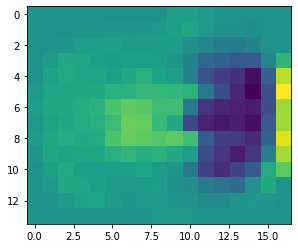

In [185]:
# plot image
plt.imshow(data[20][2])
plt.savefig('../presentation/images/brain_data.png')

In [196]:
U_fft = fft(data,axis=0)
Uc = U_fft[1]
U3d = np.zeros(shape=[3,3,14,17],dtype=complex)
U3d[0] = Uc
U3d[1] = Uc
U3d[2] = Uc
U3d = U3d.transpose(1, 2, 3, 0)
U3d.shape

(3, 14, 17, 3)

In [197]:
f = 0
Ux = U3d[0]
Uy = U3d[1]
Uz = U3d[2]
G = np.zeros(shape=[nx,ny,nz])
for i in range(1,nx-1):
    for j in range(1,ny-1):
        for k in range(1,nz-1):
            volume = dx*dy*dz
            p = [Ux[i,j,k]*volume, Uy[i,j,k]*volume, Uz[i,j,k]*volume]
            dV = [dx,dy,dz]
            Uxxy = DUdxdy(Ux,dV,i,j,k)
            Uyxy = DUdxdy(Uy,dV,i,j,k)
            Uzxy = DUdxdy(Uz,dV,i,j,k)
            Uxxz = DUdxdz(Ux,dV,i,j,k)
            Uyxz = DUdxdz(Uy,dV,i,j,k)
            Uzxz = DUdxdz(Uz,dV,i,j,k)
            Uxyz = DUdydz(Ux,dV,i,j,k)
            Uyyz = DUdydz(Uy,dV,i,j,k)
            Uzyz = DUdydz(Uz,dV,i,j,k)
            bx = [Uxyz[0], 0.5*(Uxyz[1]+Uyyz[0]), 0.5*(Uxyz[2]+Uzyz[0])]
            by = [0.5*(Uxxz[1]+Uyxz[0]), Uyxz[1], 0.5*(Uyxz[2]+Uzxz[1])]
            bz = [0.5*(Uxxy[2]+Uzxy[0]), 0.5*(Uyxy[2]+Uzxy[1]), Uzxy[2]]
            b = [bx[n] + by[n] + bz[n] for n in range(0,3)]
            
            # Evaluation of shear modulus
            G[i,j,k] =-rho*(2*np.pi*freq[f])**2/abs(np.vdot(b,b))*abs(np.vdot(b,p))
            
            
            


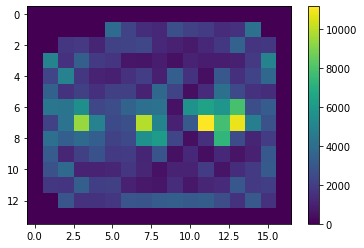

In [198]:
plt.imshow(abs(G[:,:,1]))
plt.colorbar()
plt.clim(abs(G).min(),abs(G).max()) 
plt.savefig('../presentation/images/shear_brain.png')

In [199]:
Gnorm = abs(G[:,:,1]).mean() #np.linalg.norm(abs(G[:,:,1]),2)

In [182]:
Gnorm

1865.6207599112706